# SAX Quick Start

Let's go over the core functionality of SAX.

## Imports

In [1]:
import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.experimental.optimizers as opt

# GPU setup
#%env XLA_FLAGS=--xla_gpu_cuda_data_dir=path/to/cuda
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-10.0

# sax circuit simulator
import sys
sys.path.append("..")
import sax

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda-10.0


## Models

Models are simply defined by a single function per S-matrix combination. This function takes a dictionary of parameters as single argument. For example a directional coupler:

In [2]:
def model_directional_coupler_coupling(params):
    return 1j * params["coupling"] ** 0.5

def model_directional_coupler_transmission(params):
    return (1 - params["coupling"]) ** 0.5

These model functions can then be combined into a dictionary, which basically defines the full S-matrix for a directional coupler which is defined as follows:

```
 p3          p2
   \        /
    ========
   /        \
 p0          p1
```

In [3]:
directional_coupler = {
    ("p0", "p1"): model_directional_coupler_transmission,
    ("p1", "p0"): model_directional_coupler_transmission,
    ("p2", "p3"): model_directional_coupler_transmission,
    ("p3", "p2"): model_directional_coupler_transmission,
    ("p0", "p2"): model_directional_coupler_coupling,
    ("p2", "p0"): model_directional_coupler_coupling,
    ("p1", "p3"): model_directional_coupler_coupling,
    ("p3", "p1"): model_directional_coupler_coupling,
    "default_params": {
        "coupling": 0.5
    },
}

Any non-existing S-matrix combination (for example `("p0", "p3")`) is considered to be zero. Moreover, default parameters can be defined for the full component by specifying the `"default_params"` key in the dictionary. Also note that ALL parameters in the parameter dictionary should be floats!

We can do the same for a waveguide:

```
 in -------- out
```

In [4]:
def model_waveguide_transmission(params):
    neff = params["neff"]
    dwl = params["wl"] - params["wl0"]
    dneff_dwl = (params["ng"] - params["neff"]) / params["wl0"]
    neff = neff - dwl * dneff_dwl
    phase = jnp.exp(
        jnp.log(2 * jnp.pi * neff * params["length"]) - jnp.log(params["wl"])
    )
    return 10 ** (-params["loss"] * params["length"] / 20) * jnp.exp(1j * phase)

waveguide = {
    ("in", "out"): model_waveguide_transmission,
    ("out", "in"): model_waveguide_transmission,
    "default_params": { # remember that ALL params should be floats!
        "length": 25e-6,
        "wl": 1.55e-6,
        "wl0": 1.55e-6,
        "neff": 2.34,
        "ng": 3.4,
        "loss": 0.0,
    },
}

That's all you have to do to define a component! Also note that all ports of a component can be obtained with `sax.get_ports`:

In [5]:
sax.get_ports(directional_coupler)

('p0', 'p1', 'p2', 'p3')

And ports can be renamed with `sax.rename_ports`:

In [6]:
directional_coupler2 = sax.rename_ports(
    model=directional_coupler,
    ports={
        "p0": "in1", 
        "p1": "out1", 
        "p2": "out2", 
        "p3": "in2"
    }
)
directional_coupler2

{('in1',
  'out1'): <function __main__.model_directional_coupler_transmission(params)>,
 ('out1',
  'in1'): <function __main__.model_directional_coupler_transmission(params)>,
 ('out2',
  'in2'): <function __main__.model_directional_coupler_transmission(params)>,
 ('in2',
  'out2'): <function __main__.model_directional_coupler_transmission(params)>,
 ('in1',
  'out2'): <function __main__.model_directional_coupler_coupling(params)>,
 ('out2',
  'in1'): <function __main__.model_directional_coupler_coupling(params)>,
 ('out1',
  'in2'): <function __main__.model_directional_coupler_coupling(params)>,
 ('in2',
  'out1'): <function __main__.model_directional_coupler_coupling(params)>,
 'default_params': {'coupling': 0.5}}

Note that this NEVER changes anything inplace. The original directional coupler dictionary is still intact:

In [7]:
directional_coupler

{('p0',
  'p1'): <function __main__.model_directional_coupler_transmission(params)>,
 ('p1',
  'p0'): <function __main__.model_directional_coupler_transmission(params)>,
 ('p2',
  'p3'): <function __main__.model_directional_coupler_transmission(params)>,
 ('p3',
  'p2'): <function __main__.model_directional_coupler_transmission(params)>,
 ('p0', 'p2'): <function __main__.model_directional_coupler_coupling(params)>,
 ('p2', 'p0'): <function __main__.model_directional_coupler_coupling(params)>,
 ('p1', 'p3'): <function __main__.model_directional_coupler_coupling(params)>,
 ('p3', 'p1'): <function __main__.model_directional_coupler_coupling(params)>,
 'default_params': {'coupling': 0.5}}

## Circuits

Circuits can be created with `sax.circuit`. This function takes three required arguments: `models`, `connections` and `ports`. These are all supposed to be dictionaries. The `models` dictionary describes the individual models and their name in the circuit. Note that a circuit is itself also a model, which allows you to define hierarchical circuits. The `connections` dictionary describes the connections between individual model ports. The model ports are defined as `"{modelname}:{portname}"`. Finally, the ports dictionary defines a mapping from the unused ports in the `"{modelname}:{portname}"` format back onto a single `"{portname}"`.

```
                              top
                          in ----- out
    in2 <- p3         p2                 p3         p2 -> out2
             \  dc1  /                     \  dc2  /
              =======                       =======
             /       \                     /       \
    in1 <- p0         p1      btm       p0          p1 -> out1
                          in ----- out
```

In [8]:
mzi = sax.circuit(
    models = {
        "dc1": directional_coupler,
        "top": waveguide,
        "dc2": directional_coupler,
        "btm": waveguide,
    },
    connections={
        "dc1:p2": "top:in",
        "dc1:p1": "btm:in",
        "top:out": "dc2:p3",
        "btm:out": "dc2:p0",
    },
    ports={
        "dc1:p3": "in2",
        "dc1:p0": "in1",
        "dc2:p2": "out2",
        "dc2:p1": "out1",
    },
)

As you can see, the `mzi` circuit is just a dictionary of individual functions as well:

In [9]:
mzi

{'default_params': {'dc2': {'coupling': 0.5},
  'btm': {'length': 2.5e-05,
   'wl': 1.55e-06,
   'wl0': 1.55e-06,
   'neff': 2.34,
   'ng': 3.4,
   'loss': 0.0},
  'dc1': {'coupling': 0.5},
  'top': {'length': 2.5e-05,
   'wl': 1.55e-06,
   'wl0': 1.55e-06,
   'neff': 2.34,
   'ng': 3.4,
   'loss': 0.0}},
 ('out1', 'in1'): <function _model_ijkl at 0x7fa5ca0deb90>,
 ('out1', 'in2'): <function _model_ijkl at 0x7fa5ca0deb90>,
 ('in1', 'out1'): <function _model_ijkl at 0x7fa5ca0deb90>,
 ('in1', 'out2'): <function _model_ijkl at 0x7fa5ca0deb90>,
 ('in2', 'out1'): <function _model_ijkl at 0x7fa5ca0deb90>,
 ('in2', 'out2'): <function _model_ijkl at 0x7fa5ca0deb90>,
 ('out2', 'in1'): <function _model_ijkl at 0x7fa5ca0deb90>,
 ('out2', 'in2'): <function _model_ijkl at 0x7fa5ca0deb90>}

As you can see, as for the individual components it's only defined for nonzero connections!

It also has default parameters for each of its subcomponents:

In [10]:
params = mzi["default_params"]
params

{'dc2': {'coupling': 0.5},
 'btm': {'length': 2.5e-05,
  'wl': 1.55e-06,
  'wl0': 1.55e-06,
  'neff': 2.34,
  'ng': 3.4,
  'loss': 0.0},
 'dc1': {'coupling': 0.5},
 'top': {'length': 2.5e-05,
  'wl': 1.55e-06,
  'wl0': 1.55e-06,
  'neff': 2.34,
  'ng': 3.4,
  'loss': 0.0}}

## Simulating the MZI

To simulate the MZI, we first need to update the parameters. To do this, we first copy the params dictionary after which we can update it inplace:

In [11]:
params = sax.copy_params(params)
params["btm"]["length"] = 1.5e-5 # make the bottom length shorter

Moreover, we want to simulate over a range of wavelengths. To set the wavelength globally for all subcomponents of the circuit, we use `sax.set_global_params`:

In [12]:
params = sax.set_global_params(params, wl=1e-6*jnp.linspace(1.51, 1.59, 500))

This sets the wavelength `wl` parameter for all subcomponents in the circuit.

Assume we're interested in simulating the `in1 -> out1` transmission. In this case our function of interest is given by the following:

In [13]:
mzi_in1_out1 = mzi["in1","out1"]

We can just-in-time (jit) compile this function for better performance:

In [14]:
mzi_in1_out1 = jax.jit(mzi["in1", "out1"])

The first time you simulate, the function will be jitted and the simulation will be a bit slower:

In [15]:
%time detected = mzi_in1_out1(params)

CPU times: user 334 ms, sys: 65.4 ms, total: 399 ms
Wall time: 328 ms


The second time you simulate the simulation is really fast:

In [16]:
%time detected = mzi_in1_out1(params)

CPU times: user 2.71 ms, sys: 914 µs, total: 3.62 ms
Wall time: 981 µs


Even if you change the parameters:

In [17]:
params = sax.set_global_params(params, wl=1e-6*jnp.linspace(1.5, 1.6, 500))
%time detected = mzi_in1_out1(params)

CPU times: user 1.99 ms, sys: 541 µs, total: 2.53 ms
Wall time: 785 µs


**Unless the shape of one of the parameters changes**, then the model needs to be jit-compiled again

In [18]:
params = sax.set_global_params(params, wl=1e-6*jnp.linspace(1.5, 1.6, 1000))
%time detected = mzi_in1_out1(params)

CPU times: user 450 ms, sys: 31.6 ms, total: 482 ms
Wall time: 394 ms


Luckily, now both shapes yield fast computations (we don't lose the old jit-compiled model):

In [19]:
params = sax.set_global_params(params, wl=1e-6*jnp.linspace(1.5, 1.6, 500))
%time detected = mzi_in1_out1(params)
params = sax.set_global_params(params, wl=1e-6*jnp.linspace(1.5, 1.6, 1000))
%time detected = mzi_in1_out1(params)

CPU times: user 1.75 ms, sys: 1.16 ms, total: 2.91 ms
Wall time: 906 µs
CPU times: user 2.2 ms, sys: 267 µs, total: 2.46 ms
Wall time: 819 µs


Anyway, let's see what this gives:

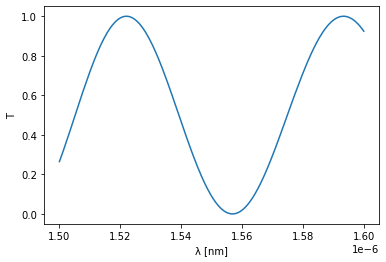

In [20]:
plt.plot(params["top"]["wl"], abs(detected)**2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.show()

## Optimization

We'd like to optimize an MZI such that one of the minima is at 1550nm. To do this, we need to define a loss function for the circuit at 1550nm. This function should take the parameters that you want to optimize as positional arguments:

In [21]:
@jax.jit
def loss(delta_length):
    params = sax.set_global_params(mzi["default_params"], wl=1.55e-6)
    params["top"]["length"] = 1.5e-6 + delta_length
    params["btm"]["length"] = 1.5e-6
    detected = mzi["in1", "out1"](params)
    return (abs(detected)**2).mean()

In [22]:
%time loss(10e-6)

CPU times: user 192 ms, sys: 19.1 ms, total: 211 ms
Wall time: 299 ms


DeviceArray(0.08960123, dtype=float32)

We can use this loss function to define a grad function which works on the parameters of the loss function:

In [23]:
grad = jax.jit(jax.grad(loss))

In [24]:
%time grad(10e-6)

CPU times: user 178 ms, sys: 16 ms, total: 194 ms
Wall time: 242 ms


DeviceArray(2709172., dtype=float32)

Next, we need to define a JAX optimizer, which on its own is nothing more than three more functions:  an initialization function with which to initialize the optimizer state, an update function which will update the optimizer state (and with it the model parameters). The third function that's being returned will give the model parameters given the optimizer state.

In [25]:
initial_delta_length = 10e-6
optim_init, optim_update, optim_params = opt.adam(step_size=1e-7)
optim_state = optim_init(initial_delta_length)

Given all this, a single training step can be defined:

In [26]:
@jax.jit
def train_step(step, optim_state):
    params = optim_params(optim_state)
    lossvalue = loss(params)
    gradvalue = grad(params)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state

And we can use this step function to start the training of the MZI:

In [27]:
range_ = tqdm.trange(1000)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

100%|██████████| 1000/1000 [00:01<00:00, 750.86it/s, loss=0.000000]


In [28]:
delta_length = optim_params(optim_state)
delta_length

Buffer(9.935911e-06, dtype=float32)

Let's see what we've got over a range of wavelengths:

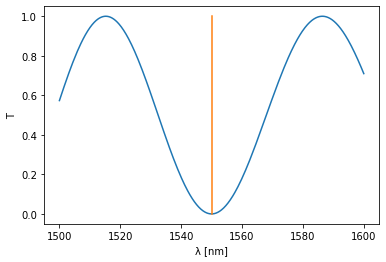

In [29]:
params = sax.set_global_params(mzi["default_params"], wl=1e-6*jnp.linspace(1.5, 1.6, 1000))
params["top"]["length"] = 1.5e-5 + delta_length
params["btm"]["length"] = 1.5e-5
detected = mzi["in1", "out1"](params)
plt.plot(params["top"]["wl"]*1e9, abs(detected)**2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.plot([1550, 1550], [0,1])
plt.show()

The minimum of the MZI is perfectly located at 1550nm.

## MZI Chain

Let's now create a chain of MZIs. For this, we first create a subcomponent: a directional coupler with arms:


```
                             top
                         in ----- out -> out2
    in2 <- p3        p2                 
             \  dc  /                  
              ======                  
             /      \                
    in1 <- p0        p1      btm    
                         in ----- out -> out1
```

In [30]:
from sax.models.pic import directional_coupler, waveguide

In [31]:
directional_coupler_with_arms = sax.circuit(
    models = {
        "dc": directional_coupler,
        "top": waveguide,
        "btm": waveguide,
    },
    connections={
        "dc:p2": "top:in",
        "dc:p1": "btm:in",
    },
    ports={
        "dc:p3": "in2",
        "dc:p0": "in1",
        "top:out": "out2",
        "btm:out": "out1",
    },
)

An MZI chain can now be created by cascading these directional couplers with arms:

```
      _    _    _    _             _    _  
    \/   \/   \/   \/     ...    \/   \/   
    /\_  /\_  /\_  /\_           /\_  /\_  
```

In [32]:
def mzi_chain(num_mzis=1):
    chain = sax.circuit(
        models = {f"dc{i}": directional_coupler_with_arms for i in range(num_mzis+1)},
        connections = {
            **{f"dc{i}:out1":f"dc{i+1}:in1" for i in range(num_mzis)},
            **{f"dc{i}:out2":f"dc{i+1}:in2" for i in range(num_mzis)},
        },
        ports = {
            "dc0:in1": "in1",
            "dc0:in2": "in2",
            f"dc{num_mzis}:out1": "out1",
            f"dc{num_mzis}:out2": "out2",
        },
    )
    return chain

Let's for example create a chain with 15 MZIs:

In [33]:
chain = mzi_chain(num_mzis=15)
params = sax.copy_params(chain["default_params"])
for dc in params:
    params[dc]["btm"]["length"] = 1.5e-5
params = sax.set_global_params(params, wl=1e-6*jnp.linspace(1.5, 1.6, 1000))

We can simulate this again:

In [34]:
%time detected = chain["in1", "out1"](params)

CPU times: user 9.25 s, sys: 1.47 s, total: 10.7 s
Wall time: 7.76 s


This takes a few seconds to simulate, so maybe it's worth jitting:

In [35]:
chain_in1_out1 = jax.jit(chain["in1", "out1"])

In [36]:
%time detected = chain_in1_out1(params)

CPU times: user 1min 20s, sys: 3.58 s, total: 1min 24s
Wall time: 1min 14s


Jit-compiling the function took even longer! However, after the jit-operation the simulation of the MZI chain becomes really fast:

In [37]:
%time detected = chain_in1_out1(params)

CPU times: user 11.5 ms, sys: 5.1 ms, total: 16.6 ms
Wall time: 5.45 ms


Anyway, let's see what this gives:

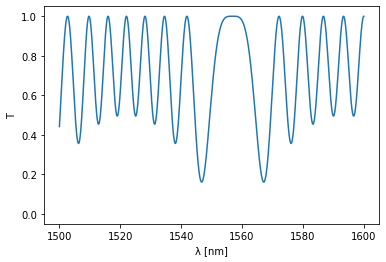

In [38]:
plt.plot(1e9*params["dc0"]["top"]["wl"], abs(detected)**2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.show()